In [1]:
# =========================
# Step 1 (updated). Build datasets:
#   (A) Kazakhstan only
#   (B) Central Asia-3: KAZ + UZB + TKM
# =========================

import os
import re
import glob
import numpy as np
import pandas as pd

DATA_DIR = "/content"
OUT_DIR  = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

ISO_KAZ = {"KAZ"}
ISO_CA3 = {"KAZ", "UZB", "TKM"}  # exclude KGZ, TJK due to insufficient observations

def infer_year(path: str) -> int:
    m = re.search(r"_(\d{4})_(flare_list|country_summary)\.csv$", os.path.basename(path))
    if not m:
        raise ValueError(f"Cannot infer year from: {path}")
    return int(m.group(1))

def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().strip('"').strip("'") for c in df.columns]
    return df

def replace_missing_minus9999(df: pd.DataFrame, numeric_cols: list) -> pd.DataFrame:
    df = df.copy()
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
            df.loc[df[col] <= -9990, col] = np.nan
    return df

# ---- 1A) Merge flare_list across years
flare_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*_flare_list.csv")))
if len(flare_paths) == 0:
    raise FileNotFoundError(f"No '*_flare_list.csv' found in {DATA_DIR}")

flare_dfs = []
for p in flare_paths:
    year = infer_year(p)
    df = pd.read_csv(p)
    df = clean_columns(df)
    df["year"] = year
    flare_dfs.append(df)

df_flare_all = pd.concat(flare_dfs, ignore_index=True)

# Normalize ISO code
df_flare_all["cntry_iso"] = df_flare_all["cntry_iso"].astype(str).str.strip().str.replace('"', "")

# Missing value handling (-9999)
flare_numeric = ["id_number", "latitude", "longitude", "flr_volume", "avg_temp", "ellip", "dtc_freq", "clr_obs"]
df_flare_all = replace_missing_minus9999(df_flare_all, flare_numeric)

# Keep rows with coordinates
df_flare_all = df_flare_all.dropna(subset=["latitude", "longitude"])

# ---- 1B) Build flare datasets
df_kaz_flare = df_flare_all[df_flare_all["cntry_iso"].isin(ISO_KAZ)].copy()
df_ca3_flare = df_flare_all[df_flare_all["cntry_iso"].isin(ISO_CA3)].copy()

out_kaz_flare = os.path.join(OUT_DIR, "kazakhstan_flare_list_2012_2019.csv")
out_ca3_flare = os.path.join(OUT_DIR, "ca3_flare_list_2012_2019.csv")
df_kaz_flare.to_csv(out_kaz_flare, index=False)
df_ca3_flare.to_csv(out_ca3_flare, index=False)

# ---- 1C) Merge country_summary across years
summary_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*_country_summary.csv")))
if len(summary_paths) == 0:
    raise FileNotFoundError(f"No '*_country_summary.csv' found in {DATA_DIR}")

sum_dfs = []
for p in summary_paths:
    year = infer_year(p)
    df = pd.read_csv(p)
    df = clean_columns(df)
    df["year"] = year
    sum_dfs.append(df)

df_sum_all = pd.concat(sum_dfs, ignore_index=True)
df_sum_all["cntry_iso"] = df_sum_all["cntry_iso"].astype(str).str.strip().str.replace('"', "")

# Convert all non-id columns to numeric and replace -9999
for col in df_sum_all.columns:
    if col in ["cntry_iso", "cntry_name", "year"]:
        continue
    df_sum_all[col] = pd.to_numeric(df_sum_all[col], errors="coerce")
    df_sum_all.loc[df_sum_all[col] <= -9990, col] = np.nan

df_kaz_sum = df_sum_all[df_sum_all["cntry_iso"].isin(ISO_KAZ)].copy()
df_ca3_sum = df_sum_all[df_sum_all["cntry_iso"].isin(ISO_CA3)].copy()

out_kaz_sum = os.path.join(OUT_DIR, "kazakhstan_country_summary_2012_2019.csv")
out_ca3_sum = os.path.join(OUT_DIR, "ca3_country_summary_2012_2019.csv")
df_kaz_sum.to_csv(out_kaz_sum, index=False)
df_ca3_sum.to_csv(out_ca3_sum, index=False)

# ---- 1D) Report
def report(df, name):
    print(f"{name}: rows={len(df):,}, sites={df['catalog_id'].nunique() if 'catalog_id' in df.columns else 'n/a'}")
    print(df["cntry_iso"].value_counts().to_string())
    print("Years:", sorted(df["year"].unique().tolist()) if "year" in df.columns else "n/a")
    print()

print("Saved files:")
print(out_kaz_flare)
print(out_ca3_flare)
print(out_kaz_sum)
print(out_ca3_sum)
print()

report(df_kaz_flare, "Kazakhstan flare_list")
report(df_ca3_flare, "CA3 (KAZ+UZB+TKM) flare_list")


Saved files:
/content/outputs/kazakhstan_flare_list_2012_2019.csv
/content/outputs/ca3_flare_list_2012_2019.csv
/content/outputs/kazakhstan_country_summary_2012_2019.csv
/content/outputs/ca3_country_summary_2012_2019.csv

Kazakhstan flare_list: rows=1,028, sites=499
cntry_iso
KAZ    1028
Years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

CA3 (KAZ+UZB+TKM) flare_list: rows=2,163, sites=1064
cntry_iso
KAZ    1028
UZB     594
TKM     541
Years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]



In [2]:
!pip -q install geopandas shapely pyproj fiona folium branca scikit-learn matplotlib pandas numpy


In [3]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

import geopandas as gpd
from shapely.geometry import Point

import folium
from folium.plugins import MarkerCluster

OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

CA3_FLARE_PATH = os.path.join(OUT_DIR, "ca3_flare_list_2012_2019.csv")
CA3_SUM_PATH   = os.path.join(OUT_DIR, "ca3_country_summary_2012_2019.csv")

df = pd.read_csv(CA3_FLARE_PATH)
df_sum = pd.read_csv(CA3_SUM_PATH)

# Basic checks
required_cols = ["cntry_iso", "cntry_name", "year", "latitude", "longitude", "flr_volume", "dtc_freq"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in flare dataset: {missing}")

# Ensure numeric
for col in ["year", "latitude", "longitude", "flr_volume", "dtc_freq"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["latitude", "longitude", "year"]).copy()

print("Loaded CA3 flare dataset:", df.shape)
print(df["cntry_iso"].value_counts())


Loaded CA3 flare dataset: (2163, 13)
cntry_iso
KAZ    1028
UZB     594
TKM     541
Name: count, dtype: int64


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

import geopandas as gpd
from shapely.geometry import Point

import folium
from folium.plugins import MarkerCluster

OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

CA3_FLARE_PATH = os.path.join(OUT_DIR, "ca3_flare_list_2012_2019.csv")
CA3_SUM_PATH   = os.path.join(OUT_DIR, "ca3_country_summary_2012_2019.csv")

df = pd.read_csv(CA3_FLARE_PATH)
df_sum = pd.read_csv(CA3_SUM_PATH)

# Проверка ключевых колонок
required_cols = ["cntry_iso", "cntry_name", "year", "latitude", "longitude", "flr_volume", "dtc_freq"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Нет нужных колонок в датасете flare_list: {missing}")

# Приведение типов
for col in ["year", "latitude", "longitude", "flr_volume", "dtc_freq"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["latitude", "longitude", "year"]).copy()

print("Загружен датасет CA3 (flare_list):", df.shape)
print("Распределение по странам:")
print(df["cntry_iso"].value_counts().to_string())


Загружен датасет CA3 (flare_list): (2163, 13)
Распределение по странам:
cntry_iso
KAZ    1028
UZB     594
TKM     541


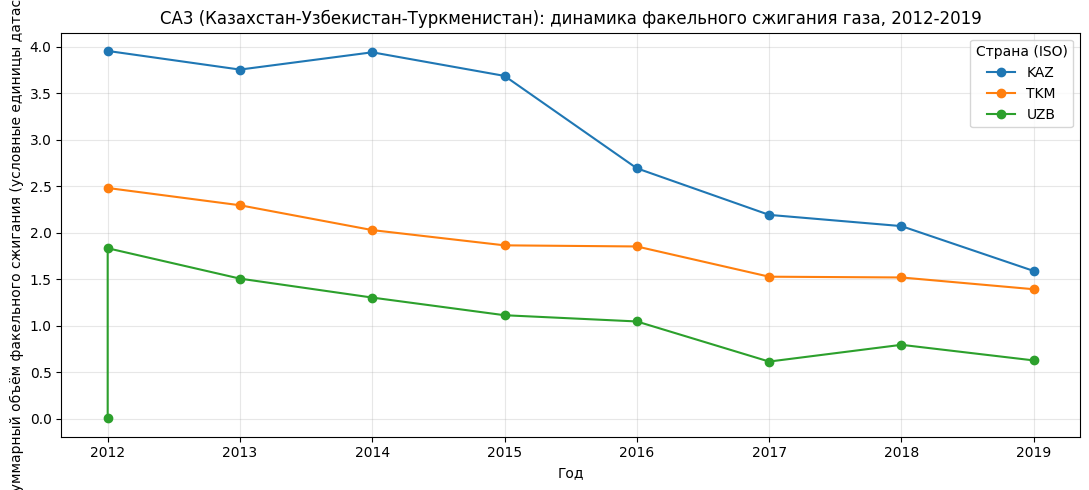

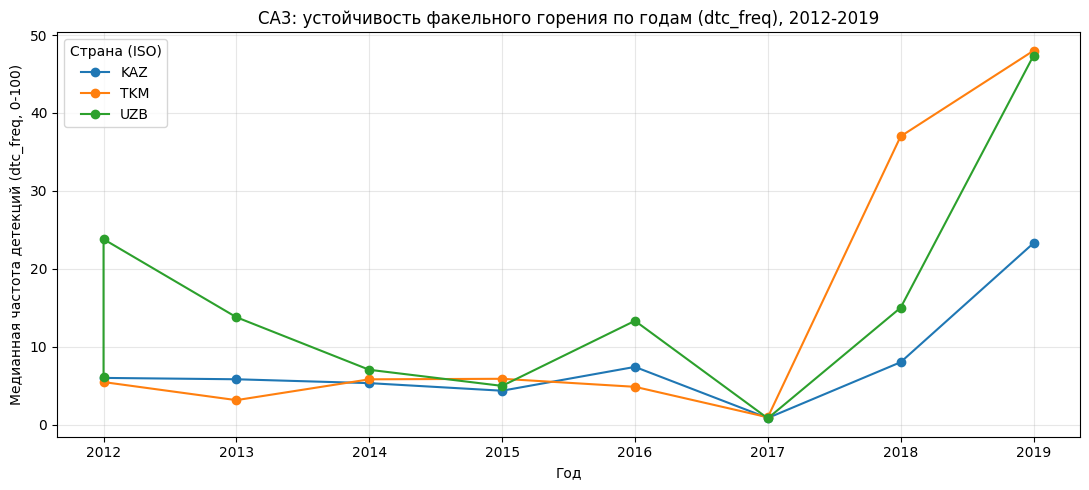

Готово: тренды сохранены в outputs/.


In [5]:
# Тренд из flare_list: сумма flr_volume по стране и году
trend = (
    df.groupby(["cntry_iso", "cntry_name", "year"])
      .agg(
          n_sites=("catalog_id", "count") if "catalog_id" in df.columns else ("latitude", "count"),
          total_flr_volume=("flr_volume", "sum"),
          median_dtc_freq=("dtc_freq", "median"),
      )
      .reset_index()
      .sort_values(["cntry_iso", "year"])
)

trend.to_csv(os.path.join(OUT_DIR, "ca3_trend_flare_list.csv"), index=False)

# График 1: суммарный объём факельного сжигания по годам
plt.figure(figsize=(11, 5))
for iso, g in trend.groupby("cntry_iso"):
    plt.plot(g["year"], g["total_flr_volume"], marker="o", label=iso)
plt.xlabel("Год")
plt.ylabel("Суммарный объём факельного сжигания (условные единицы датасета)")
plt.title("CA3 (Казахстан-Узбекистан-Туркменистан): динамика факельного сжигания газа, 2012-2019")
plt.grid(True, alpha=0.3)
plt.legend(title="Страна (ISO)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "trend_total_flaring_ru.png"), dpi=300)
plt.show()

# График 2: устойчивость/постоянство (dtc_freq) по годам
plt.figure(figsize=(11, 5))
for iso, g in trend.groupby("cntry_iso"):
    plt.plot(g["year"], g["median_dtc_freq"], marker="o", label=iso)
plt.xlabel("Год")
plt.ylabel("Медианная частота детекций (dtc_freq, 0-100)")
plt.title("CA3: устойчивость факельного горения по годам (dtc_freq), 2012-2019")
plt.grid(True, alpha=0.3)
plt.legend(title="Страна (ISO)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "trend_persistence_ru.png"), dpi=300)
plt.show()

print("Готово: тренды сохранены в outputs/.")


Интерпретация кластеров (сортировка от низкого к высокому impact):
   cluster     n  median_flr_volume  mean_flr_volume  median_dtc_freq  \
0        0  1961           0.002272         0.008843          5.74018   
1        2   182           0.105736         0.112291         95.11540   
2        1    20           0.407581         0.492821         98.43525   

   mean_dtc_freq  impact_score impact_class  
0      23.687259      0.020731       Низкий  
1      80.410991      0.361277      Средний  
2      91.428685      0.441031      Высокий  


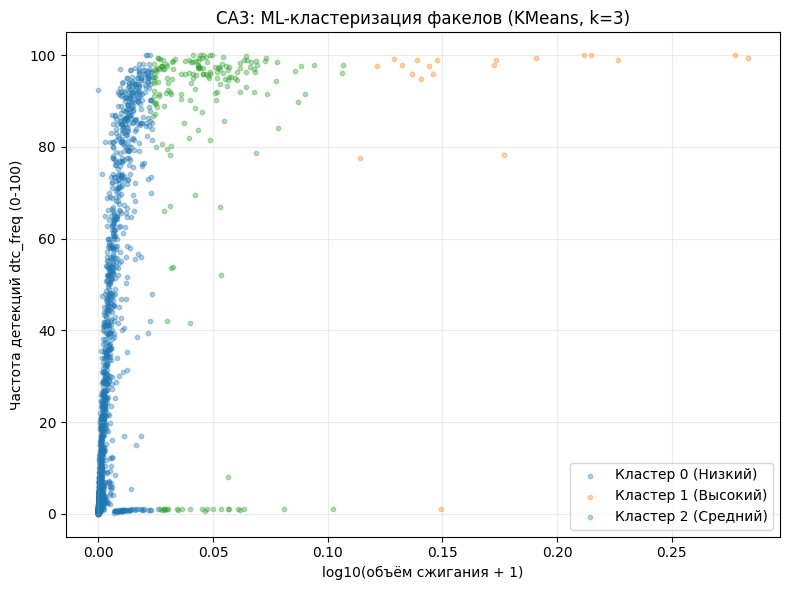

In [6]:
df_ml = df.copy()

# Признаки для ML (интерпретируемые):
# log10(flr_volume+1) -> масштаб интенсивности
# dtc_freq -> устойчивость/постоянство
df_ml["log_flr_volume"] = np.log10(df_ml["flr_volume"].fillna(0) + 1.0)
df_ml["dtc_freq_filled"] = df_ml["dtc_freq"].fillna(df_ml["dtc_freq"].median())

X = df_ml[["log_flr_volume", "dtc_freq_filled"]].values

# RobustScaler для устойчивости к выбросам
scaler = RobustScaler()
Xs = scaler.fit_transform(X)

# KMeans (k=3)
km = KMeans(n_clusters=3, random_state=42, n_init=20)
df_ml["cluster"] = km.fit_predict(Xs)

# Статистика по кластерам для интерпретации
cluster_stats = (
    df_ml.groupby("cluster")
         .agg(
             n=("cluster", "size"),
             median_flr_volume=("flr_volume", "median"),
             mean_flr_volume=("flr_volume", "mean"),
             median_dtc_freq=("dtc_freq_filled", "median"),
             mean_dtc_freq=("dtc_freq_filled", "mean"),
         )
         .reset_index()
)

# Proxy impact-score: комбинация интенсивности и устойчивости
cluster_stats["impact_score"] = (
    np.log10(cluster_stats["median_flr_volume"].fillna(0) + 1.0) * 0.65
    + (cluster_stats["median_dtc_freq"].fillna(0) / 100.0) * 0.35
)

# Упорядочиваем кластеры по impact_score
cluster_stats = cluster_stats.sort_values("impact_score").reset_index(drop=True)

# Присваиваем классы impact
impact_labels = ["Низкий", "Средний", "Высокий"]
impact_map = {int(cluster_stats.loc[i, "cluster"]): impact_labels[i] for i in range(3)}

df_ml["impact_class"] = df_ml["cluster"].map(impact_map)
cluster_stats["impact_class"] = cluster_stats["cluster"].map(impact_map)

# Сохранение
cluster_stats.to_csv(os.path.join(OUT_DIR, "ca3_cluster_interpretation_ru.csv"), index=False)
df_ml.to_csv(os.path.join(OUT_DIR, "ca3_flare_list_with_clusters.csv"), index=False)

print("Интерпретация кластеров (сортировка от низкого к высокому impact):")
print(cluster_stats)

# График кластеров (для презентации)
plt.figure(figsize=(8, 6))
for c in sorted(df_ml["cluster"].unique()):
    g = df_ml[df_ml["cluster"] == c]
    plt.scatter(
        g["log_flr_volume"], g["dtc_freq_filled"],
        s=10, alpha=0.35,
        label=f"Кластер {c} ({impact_map[c]})"
    )
plt.xlabel("log10(объём сжигания + 1)")
plt.ylabel("Частота детекций dtc_freq (0-100)")
plt.title("CA3: ML-кластеризация факелов (KMeans, k=3)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "ml_clusters_scatter_ru.png"), dpi=300)
plt.show()


In [7]:
# Alerts по стране-год: z-score внутри страны
trend2 = trend.copy()

def zscore(s):
    mu = s.mean()
    sd = s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return (s - mu) * 0.0
    return (s - mu) / sd

trend2["z_total_volume_country"] = trend2.groupby("cntry_iso")["total_flr_volume"].transform(zscore)

# Порог алерта (можно менять)
ALERT_Z = 1.5

alerts_country_year = trend2[trend2["z_total_volume_country"] >= ALERT_Z].copy()
alerts_country_year = alerts_country_year.sort_values(["cntry_iso", "z_total_volume_country"], ascending=[True, False])
alerts_country_year.to_csv(os.path.join(OUT_DIR, "alerts_country_year_ru.csv"), index=False)

# Alerts по объектам: anomaly_score на уровне объект-год
tmp = df_ml.copy()
eps = 1e-9
tmp["logv_norm"] = (tmp["log_flr_volume"] - tmp["log_flr_volume"].min()) / (tmp["log_flr_volume"].max() - tmp["log_flr_volume"].min() + eps)
tmp["freq_norm"] = (tmp["dtc_freq_filled"] - tmp["dtc_freq_filled"].min()) / (tmp["dtc_freq_filled"].max() - tmp["dtc_freq_filled"].min() + eps)
tmp["anomaly_score"] = 0.65 * tmp["logv_norm"] + 0.35 * tmp["freq_norm"]

alerts_sites = (
    tmp.sort_values("anomaly_score", ascending=False)
       .head(50)[["cntry_iso", "cntry_name", "year", "catalog_id", "latitude", "longitude",
                  "flr_volume", "dtc_freq_filled", "impact_class", "anomaly_score", "flr_type"]]
)

alerts_sites.to_csv(os.path.join(OUT_DIR, "alerts_sites_top50_ru.csv"), index=False)

print("Готово: alerts сохранены.")
print("Топ алертов страна-год (preview):")
print(alerts_country_year[["cntry_iso", "year", "total_flr_volume", "z_total_volume_country"]].head(10))


Готово: alerts сохранены.
Топ алертов страна-год (preview):
   cntry_iso  year  total_flr_volume  z_total_volume_country
8        TKM  2012          2.479396                1.687887
17       UZB  2012          1.831308                1.655847


In [8]:
# =========================
# Step 5 (FIXED). Интерактивная карта с границами стран (CA3) + точки факелов
# Источник границ: Natural Earth Admin 0 (110m) - скачиваем ZIP и читаем шейпфайл
# =========================

import os
import zipfile
import requests
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster

OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- 5A) Скачиваем Natural Earth boundaries (Admin 0 Countries, 110m)
NE_URL = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
NE_ZIP_PATH = os.path.join(OUT_DIR, "ne_110m_admin_0_countries.zip")
NE_EXTRACT_DIR = os.path.join(OUT_DIR, "ne_110m_admin_0_countries")

if not os.path.exists(NE_ZIP_PATH):
    print("Скачиваю границы стран Natural Earth...")
    r = requests.get(NE_URL, stream=True, timeout=120)
    r.raise_for_status()
    with open(NE_ZIP_PATH, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)

if not os.path.exists(NE_EXTRACT_DIR):
    print("Распаковываю ZIP...")
    with zipfile.ZipFile(NE_ZIP_PATH, "r") as z:
        z.extractall(NE_EXTRACT_DIR)

# Находим .shp внутри распакованной папки
shp_candidates = []
for root, _, files in os.walk(NE_EXTRACT_DIR):
    for fn in files:
        if fn.lower().endswith(".shp"):
            shp_candidates.append(os.path.join(root, fn))

if len(shp_candidates) == 0:
    raise FileNotFoundError("Не найден .shp файл внутри Natural Earth архива.")

shp_path = shp_candidates[0]
print("Шейпфайл границ:", shp_path)

# ---- 5B) Читаем границы стран
world = gpd.read_file(shp_path).to_crs(epsg=4326)

# CA3: Казахстан, Узбекистан, Туркменистан
# В Natural Earth обычно поле NAME или ADMIN. Подстрахуемся.
name_col = None
for c in ["NAME", "ADMIN", "name", "admin"]:
    if c in world.columns:
        name_col = c
        break
if name_col is None:
    raise KeyError(f"Не нашел колонку с названием страны. Доступные колонки: {list(world.columns)}")

names_keep = ["Kazakhstan", "Uzbekistan", "Turkmenistan"]
world_ca3 = world[world[name_col].isin(names_keep)].copy()

if world_ca3.empty:
    # Иногда названия могут отличаться. Выведем уникальные на всякий случай.
    raise ValueError(
        "Не удалось отфильтровать страны по названиям. "
        f"Колонка: {name_col}. Проверь, как записаны названия в Natural Earth."
    )

# ---- 5C) Точки факелов из df_ml (предполагается, что df_ml уже в памяти из Step 3)
# Если df_ml не в памяти, можно загрузить:
# df_ml = pd.read_csv(os.path.join(OUT_DIR, "ca3_flare_list_with_clusters.csv"))

required_cols_points = ["longitude", "latitude", "impact_class", "flr_volume", "dtc_freq_filled", "year", "cntry_iso", "cntry_name"]
miss2 = [c for c in required_cols_points if c not in df_ml.columns]
if miss2:
    raise ValueError(f"df_ml не содержит нужных колонок: {miss2}. Убедись, что Step 3 был выполнен.")

gdf_points = gpd.GeoDataFrame(
    df_ml.copy(),
    geometry=[Point(xy) for xy in zip(df_ml["longitude"], df_ml["latitude"])],
    crs="EPSG:4326"
)

# ---- 5D) Создаем карту
centroid = world_ca3.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=5, tiles="CartoDB positron")

# Добавляем границы
folium.GeoJson(
    world_ca3,
    name="Границы стран (CA3)",
    style_function=lambda x: {"fillOpacity": 0.05, "weight": 2}
).add_to(m)

# Кластер маркеров
cluster = MarkerCluster(name="Факелы (кластеры точек)").add_to(m)

# Цвет по impact_class
color_map = {"Низкий": "green", "Средний": "orange", "Высокий": "red"}

def radius_from_volume(v, vmax):
    if not np.isfinite(v) or v <= 0:
        return 3
    return float(np.clip(3 + 10 * (np.log10(v + 1.0) / (np.log10(vmax + 1.0) + 1e-9)), 3, 12))

vmax = np.nanmax(gdf_points["flr_volume"].values)

for _, r in gdf_points.iterrows():
    color = color_map.get(str(r["impact_class"]), "blue")
    rad = radius_from_volume(r["flr_volume"], vmax)

    popup_html = (
        f"<b>Страна:</b> {r.get('cntry_name','')} ({r.get('cntry_iso','')})<br>"
        f"<b>Год:</b> {int(r.get('year', -1))}<br>"
        f"<b>Catalog ID:</b> {r.get('catalog_id','')}<br>"
        f"<b>Объём факельного сжигания:</b> {float(r.get('flr_volume', np.nan)):.3f}<br>"
        f"<b>Частота детекций (dtc_freq):</b> {float(r.get('dtc_freq_filled', np.nan)):.1f}<br>"
        f"<b>Класс impact:</b> {r.get('impact_class','')}<br>"
        f"<b>Тип факела:</b> {r.get('flr_type','')}"
    )

    folium.CircleMarker(
        location=(r.geometry.y, r.geometry.x),
        radius=rad,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.65,
        weight=1,
        popup=folium.Popup(popup_html, max_width=350)
    ).add_to(cluster)

folium.LayerControl(collapsed=False).add_to(m)

map_path = os.path.join(OUT_DIR, "ca3_flaring_watch_map_ru.html")
m.save(map_path)

print("Готово: интерактивная карта сохранена:", map_path)


Скачиваю границы стран Natural Earth...
Распаковываю ZIP...
Шейпфайл границ: /content/outputs/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp


/tmp/ipython-input-3769920730.py:89: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = world_ca3.unary_union.centroid


Готово: интерактивная карта сохранена: /content/outputs/ca3_flaring_watch_map_ru.html


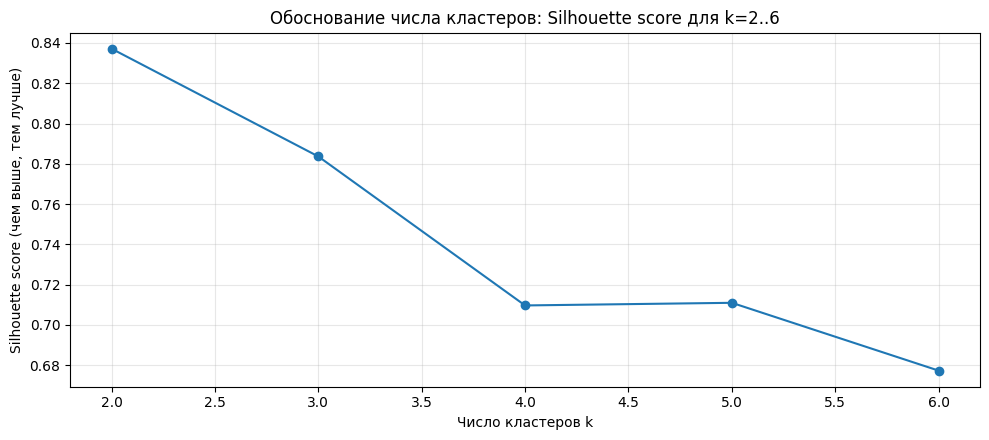

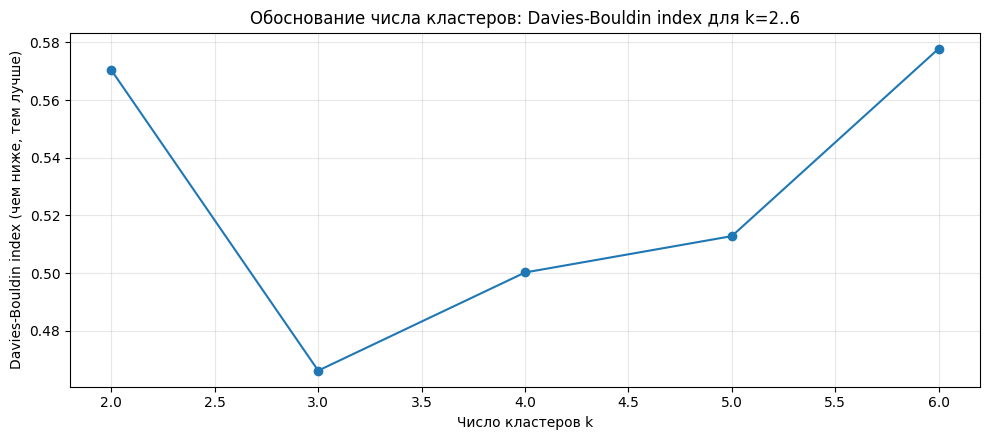

Сохранены графики выбора k:
- k_selection_silhouette_ru.png
- k_selection_davies_bouldin_ru.png


/tmp/ipython-input-284718416.py:135: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = world_ca3.unary_union.centroid


Готово: финальная продуктовая карта сохранена: /content/outputs/ca3_flaring_watch_product_ru.html
Теперь открывай этот HTML файл и делай скриншоты для презентации.


In [9]:
# =========================
# Step 6. Product map v2:
# - легенда (цвета impact)
# - слой Top-50 alerts
# - heatmap плотности
# - слои по годам (2012-2019)
# + оценка k (2..6) для обоснования k=3
# =========================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import geopandas as gpd
from shapely.geometry import Point

import folium
from folium.plugins import MarkerCluster, HeatMap
import branca

OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Load datasets
df_ml_path = os.path.join(OUT_DIR, "ca3_flare_list_with_clusters.csv")
alerts_top50_path = os.path.join(OUT_DIR, "alerts_sites_top50_ru.csv")

df_ml = pd.read_csv(df_ml_path)
df_alerts = pd.read_csv(alerts_top50_path)

# Ensure numeric columns
for col in ["year", "latitude", "longitude", "flr_volume", "dtc_freq_filled"]:
    if col in df_ml.columns:
        df_ml[col] = pd.to_numeric(df_ml[col], errors="coerce")

df_ml = df_ml.dropna(subset=["latitude", "longitude", "year"]).copy()

# ---- (A) Quick justification of k: try k=2..6
# Features used in clustering
df_ml["log_flr_volume"] = np.log10(df_ml["flr_volume"].fillna(0) + 1.0)
df_ml["dtc_freq_filled"] = df_ml["dtc_freq_filled"].fillna(df_ml["dtc_freq_filled"].median())

X = df_ml[["log_flr_volume", "dtc_freq_filled"]].values
scaler = RobustScaler()
Xs = scaler.fit_transform(X)

ks = list(range(2, 7))
sil_scores = []
db_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(Xs)
    sil = silhouette_score(Xs, labels)
    db = davies_bouldin_score(Xs, labels)
    sil_scores.append(sil)
    db_scores.append(db)

# Plot metrics (RU labels)
plt.figure(figsize=(10, 4.5))
plt.plot(ks, sil_scores, marker="o")
plt.xlabel("Число кластеров k")
plt.ylabel("Silhouette score (чем выше, тем лучше)")
plt.title("Обоснование числа кластеров: Silhouette score для k=2..6")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "k_selection_silhouette_ru.png"), dpi=300)
plt.show()

plt.figure(figsize=(10, 4.5))
plt.plot(ks, db_scores, marker="o")
plt.xlabel("Число кластеров k")
plt.ylabel("Davies-Bouldin index (чем ниже, тем лучше)")
plt.title("Обоснование числа кластеров: Davies-Bouldin index для k=2..6")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "k_selection_davies_bouldin_ru.png"), dpi=300)
plt.show()

print("Сохранены графики выбора k:")
print("- k_selection_silhouette_ru.png")
print("- k_selection_davies_bouldin_ru.png")

# ---- (B) Borders: download Natural Earth (Admin 0, 110m) if needed
import zipfile, requests

NE_URL = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
NE_ZIP_PATH = os.path.join(OUT_DIR, "ne_110m_admin_0_countries.zip")
NE_EXTRACT_DIR = os.path.join(OUT_DIR, "ne_110m_admin_0_countries")

if not os.path.exists(NE_ZIP_PATH):
    print("Скачиваю границы стран Natural Earth...")
    r = requests.get(NE_URL, stream=True, timeout=120)
    r.raise_for_status()
    with open(NE_ZIP_PATH, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)

if not os.path.exists(NE_EXTRACT_DIR):
    print("Распаковываю ZIP...")
    with zipfile.ZipFile(NE_ZIP_PATH, "r") as z:
        z.extractall(NE_EXTRACT_DIR)

# Find .shp
shp_candidates = []
for root, _, files in os.walk(NE_EXTRACT_DIR):
    for fn in files:
        if fn.lower().endswith(".shp"):
            shp_candidates.append(os.path.join(root, fn))
if len(shp_candidates) == 0:
    raise FileNotFoundError("Не найден .shp файл внутри Natural Earth архива.")
shp_path = shp_candidates[0]

world = gpd.read_file(shp_path).to_crs(epsg=4326)

# Pick name column
name_col = None
for c in ["NAME", "ADMIN", "name", "admin"]:
    if c in world.columns:
        name_col = c
        break
if name_col is None:
    raise KeyError(f"Не нашел колонку с названием страны. Колонки: {list(world.columns)}")

names_keep = ["Kazakhstan", "Uzbekistan", "Turkmenistan"]
world_ca3 = world[world[name_col].isin(names_keep)].copy()

# ---- (C) Build folium map
centroid = world_ca3.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=5, tiles="CartoDB positron")

# Borders layer
folium.GeoJson(
    world_ca3,
    name="Границы стран (CA3)",
    style_function=lambda x: {"fillOpacity": 0.05, "weight": 2}
).add_to(m)

# ---- (D) Legend (RU)
legend_html = """
<div style="
position: fixed;
bottom: 30px;
left: 30px;
z-index: 9999;
background-color: white;
padding: 10px 12px;
border: 2px solid #444;
border-radius: 6px;
font-size: 14px;
">
<b>Легенда (impact)</b><br>
<span style="display:inline-block;width:12px;height:12px;background:green;margin-right:6px;"></span>Низкий<br>
<span style="display:inline-block;width:12px;height:12px;background:orange;margin-right:6px;"></span>Средний<br>
<span style="display:inline-block;width:12px;height:12px;background:red;margin-right:6px;"></span>Высокий<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# ---- (E) Heatmap layer (density)
heat_data = df_ml[["latitude", "longitude"]].dropna().values.tolist()
heat_layer = folium.FeatureGroup(name="Тепловая карта плотности (Heatmap)", show=False)
HeatMap(heat_data, radius=12, blur=14, min_opacity=0.3).add_to(heat_layer)
heat_layer.add_to(m)

# ---- (F) Main points by year layers
color_map = {"Низкий": "green", "Средний": "orange", "Высокий": "red"}

def radius_from_volume(v, vmax):
    if not np.isfinite(v) or v <= 0:
        return 3
    return float(np.clip(3 + 10 * (np.log10(v + 1.0) / (np.log10(vmax + 1.0) + 1e-9)), 3, 12))

vmax = np.nanmax(df_ml["flr_volume"].values)

years = sorted(df_ml["year"].dropna().unique().astype(int).tolist())

for y in years:
    layer = folium.FeatureGroup(name=f"Факелы: {y}", show=(y == years[-1]))
    df_y = df_ml[df_ml["year"] == y].copy()

    # clustering markers for each year
    mc = MarkerCluster(name=f"Кластеры точек {y}").add_to(layer)

    for _, r in df_y.iterrows():
        color = color_map.get(str(r.get("impact_class", "")), "blue")
        rad = radius_from_volume(r.get("flr_volume", np.nan), vmax)

        popup_html = (
            f"<b>Страна:</b> {r.get('cntry_name','')} ({r.get('cntry_iso','')})<br>"
            f"<b>Год:</b> {int(r.get('year', -1))}<br>"
            f"<b>Catalog ID:</b> {r.get('catalog_id','')}<br>"
            f"<b>Объём сжигания:</b> {float(r.get('flr_volume', np.nan)):.3f}<br>"
            f"<b>dtc_freq:</b> {float(r.get('dtc_freq_filled', np.nan)):.1f}<br>"
            f"<b>Impact:</b> {r.get('impact_class','')}<br>"
            f"<b>Тип:</b> {r.get('flr_type','')}"
        )

        folium.CircleMarker(
            location=(float(r["latitude"]), float(r["longitude"])),
            radius=rad,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.65,
            weight=1,
            popup=folium.Popup(popup_html, max_width=360)
        ).add_to(mc)

    layer.add_to(m)

# ---- (G) Alerts Top-50 layer (separate)
alerts_layer = folium.FeatureGroup(name="ALERTS: топ-50 объектов", show=True)
for _, r in df_alerts.iterrows():
    # Use a fixed prominent style
    popup_html = (
        f"<b>ALERT (топ объект)</b><br>"
        f"<b>Страна:</b> {r.get('cntry_name','')} ({r.get('cntry_iso','')})<br>"
        f"<b>Год:</b> {int(r.get('year', -1))}<br>"
        f"<b>Catalog ID:</b> {r.get('catalog_id','')}<br>"
        f"<b>Объём сжигания:</b> {float(r.get('flr_volume', np.nan)):.3f}<br>"
        f"<b>dtc_freq:</b> {float(r.get('dtc_freq_filled', np.nan)):.1f}<br>"
        f"<b>Impact:</b> {r.get('impact_class','')}<br>"
        f"<b>anomaly_score:</b> {float(r.get('anomaly_score', np.nan)):.3f}<br>"
        f"<b>Тип:</b> {r.get('flr_type','')}"
    )

    folium.CircleMarker(
        location=(float(r["latitude"]), float(r["longitude"])),
        radius=10,
        color="black",
        fill=True,
        fill_color="yellow",
        fill_opacity=0.85,
        weight=2,
        popup=folium.Popup(popup_html, max_width=380)
    ).add_to(alerts_layer)

alerts_layer.add_to(m)

# Controls
folium.LayerControl(collapsed=False).add_to(m)

# Save
map_path = os.path.join(OUT_DIR, "ca3_flaring_watch_product_ru.html")
m.save(map_path)

print("Готово: финальная продуктовая карта сохранена:", map_path)
print("Теперь открывай этот HTML файл и делай скриншоты для презентации.")


In [12]:
# ============================================================
# STEP X. Таблицы для Word (Табл. 4.1–4.4) - исправленная версия
# ============================================================

import os
import numpy as np
import pandas as pd

# Пути к твоим готовым файлам (поправь, если у тебя другие имена)
PATH_FLARES = "/content/outputs/ca3_flare_list_with_clusters.csv"
PATH_ALERTS_COUNTRY_YEAR = "/content/outputs/alerts_country_year_ru.csv"
PATH_ALERTS_TOP50 = "/content/outputs/alerts_sites_top50_ru.csv"

OUT_DIR = "/content/outputs/tables_for_word"
os.makedirs(OUT_DIR, exist_ok=True)

# --- CA3 по ISO (как ты и хотел) ---
CA3_ISO = ["KAZ", "UZB", "TKM"]

# Канонические названия стран (для таблиц/презентации)
ISO_TO_COUNTRY_RU = {
    "KAZ": "Казахстан",
    "UZB": "Узбекистан",
    "TKM": "Туркменистан",
}

ISO_TO_COUNTRY_EN = {
    "KAZ": "Kazakhstan",
    "UZB": "Uzbekistan",
    "TKM": "Turkmenistan",
}

def safe_read_csv(path: str) -> pd.DataFrame:
    """
    Читает CSV максимально устойчиво к кодировкам.
    В Colab обычно UTF-8, но добавим fallback.
    """
    try:
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="utf-8", engine="python")

def coerce_numeric(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def format_min_max(a, b, digits=4):
    if pd.isna(a) or pd.isna(b):
        return ""
    return f"{a:.{digits}f}–{b:.{digits}f}"

# ---------------------------
# 1) Загрузка flare-листа
# ---------------------------
df = safe_read_csv(PATH_FLARES)
df.columns = [c.strip() for c in df.columns]

# Важные колонки по твоему списку (проверяем, что есть)
# cntry_name, cntry_iso, catalog_id, id_number, latitude, longitude, flr_volume,
# avg_temp, ellip, dtc_freq, clr_obs, flr_type, year + наши поля cluster/impact
needed = ["cntry_iso", "cntry_name", "catalog_id", "id_number",
          "latitude", "longitude", "flr_volume", "avg_temp", "ellip",
          "dtc_freq", "clr_obs", "flr_type", "year", "cluster", "impact_class"]

# Фильтр CA3
if "cntry_iso" not in df.columns:
    raise ValueError("Не найдена колонка cntry_iso в flare_list_with_clusters.csv")

df["cntry_iso"] = df["cntry_iso"].astype(str).str.strip().str.upper()
df = df[df["cntry_iso"].isin(CA3_ISO)].copy()

# Чистим/приводим типы
df = coerce_numeric(df, ["latitude", "longitude", "flr_volume", "avg_temp", "ellip", "dtc_freq", "clr_obs", "year", "cluster"])
df["year"] = df["year"].astype("Int64")

# ВАЖНО: названия стран берем только из ISO (исправляет дубль и “Turkmenistan UZB”)
df["country_ru"] = df["cntry_iso"].map(ISO_TO_COUNTRY_RU)
df["country_en"] = df["cntry_iso"].map(ISO_TO_COUNTRY_EN)

# Убираем бесполезный id_number, если он весь -9999/NaN
if "id_number" in df.columns:
    if df["id_number"].isna().mean() > 0.9 or (df["id_number"] == -9999).mean() > 0.9:
        df.drop(columns=["id_number"], inplace=True)

# На всякий случай: отрицательные flr_volume не допускаем (если вдруг из-за мусора)
if "flr_volume" in df.columns:
    df.loc[df["flr_volume"] < 0, "flr_volume"] = np.nan

# -----------------------------------------
# 2) Пересборка impact_class (если надо)
# -----------------------------------------
# Логика:
# - строим impact_score = z(log1p(flr_volume)) + z(dtc_freq)
# - ранжируем кластеры по медиане impact_score
# - присваиваем "Низкий/Средний/Высокий"
def zscore(x):
    x = x.astype(float)
    mu = np.nanmean(x)
    sd = np.nanstd(x)
    if sd == 0 or np.isnan(sd):
        return x * 0.0
    return (x - mu) / sd

# dtc_freq может называться по-другому в твоей сборке; поддержим fallback
dtc_col = "dtc_freq"
if "dtc_freq_filled" in df.columns:
    dtc_col = "dtc_freq_filled"

# Если нужных колонок нет - impact-кластеризация невозможна (но у тебя они есть)
if "cluster" not in df.columns or "flr_volume" not in df.columns or dtc_col not in df.columns:
    raise ValueError("Не хватает колонок cluster/flr_volume/dtc_freq(_filled) для пересборки impact_class")

df["_log_flr_volume"] = np.log1p(df["flr_volume"])
df["_z_log_flr"] = zscore(df["_log_flr_volume"].fillna(df["_log_flr_volume"].median()))
df["_z_dtc"] = zscore(df[dtc_col].fillna(df[dtc_col].median()))
df["_impact_score"] = df["_z_log_flr"] + df["_z_dtc"]

# Профиль по кластерам
cluster_med = (
    df.groupby("cluster", dropna=False)["_impact_score"]
      .median()
      .sort_values()
)

# Если кластеров не 3, все равно работаем, но метки дадим по квантилям
clusters_sorted = list(cluster_med.index)

def assign_impact_label(rank, n):
    # Для n=3: 0=Low, 1=Medium, 2=High
    if n == 3:
        return ["Низкий", "Средний", "Высокий"][rank]
    # Для n!=3: разобьем по терцилям ранга
    q1 = int(np.floor((n-1) / 3))
    q2 = int(np.floor(2*(n-1) / 3))
    if rank <= q1:
        return "Низкий"
    elif rank <= q2:
        return "Средний"
    return "Высокий"

cluster_to_label = {c: assign_impact_label(i, len(clusters_sorted)) for i, c in enumerate(clusters_sorted)}
df["impact_class"] = df["cluster"].map(cluster_to_label)

# -----------------------------------------
# 3) Таблица 4.1 - сводка по странам
# -----------------------------------------
df_valid = df.copy()
df_valid = df_valid[df_valid["year"].notna()].copy()

total_n = len(df_valid)

def years_period(x):
    y0 = int(x.min())
    y1 = int(x.max())
    return f"{y0}–{y1}"

# Собираем только реально заполненные метрики
cols_present = set(df_valid.columns)

use_clr = "clr_obs" if "clr_obs" in cols_present else None
use_dtc = dtc_col if dtc_col in cols_present else None

rows_41 = []
for iso in CA3_ISO:
    dfi = df_valid[df_valid["cntry_iso"] == iso].copy()
    n = len(dfi)
    share = 100.0 * n / total_n if total_n else 0.0

    y = dfi["year"].dropna()
    period = years_period(y) if len(y) else ""
    n_years = int(y.nunique()) if len(y) else 0

    flr_mean = float(np.nanmean(dfi["flr_volume"])) if n else np.nan
    flr_med = float(np.nanmedian(dfi["flr_volume"])) if n else np.nan
    flr_min = float(np.nanmin(dfi["flr_volume"])) if n else np.nan
    flr_max = float(np.nanmax(dfi["flr_volume"])) if n else np.nan

    dtc_med = float(np.nanmedian(dfi[use_dtc])) if (use_dtc and n) else np.nan
    clr_med = float(np.nanmedian(dfi[use_clr])) if (use_clr and n) else np.nan

    rows_41.append({
        "Страна": ISO_TO_COUNTRY_RU[iso],
        "ISO": iso,
        "Кол-во_точек": n,
        "Доля_от_общего_%": round(share, 2),
        "Период_годы": period,
        "Число_лет": n_years,
        "flr_volume_среднее": round(flr_mean, 4) if np.isfinite(flr_mean) else "",
        "flr_volume_медиана": round(flr_med, 4) if np.isfinite(flr_med) else "",
        "flr_volume_min–max": format_min_max(flr_min, flr_max, digits=4) if np.isfinite(flr_min) and np.isfinite(flr_max) else "",
        "dtc_freq_медиана": round(dtc_med, 4) if np.isfinite(dtc_med) else "",
        "clr_obs_медиана": round(clr_med, 1) if np.isfinite(clr_med) else "",
    })

# Итого
rows_41.append({
    "Страна": "Итого CA3",
    "ISO": "-",
    "Кол-во_точек": total_n,
    "Доля_от_общего_%": 100.00,
    "Период_годы": years_period(df_valid["year"].dropna()) if total_n else "",
    "Число_лет": int(df_valid["year"].nunique()) if total_n else 0,
    "flr_volume_среднее": round(float(np.nanmean(df_valid["flr_volume"])), 4) if total_n else "",
    "flr_volume_медиана": round(float(np.nanmedian(df_valid["flr_volume"])), 4) if total_n else "",
    "flr_volume_min–max": format_min_max(float(np.nanmin(df_valid["flr_volume"])), float(np.nanmax(df_valid["flr_volume"])), 4) if total_n else "",
    "dtc_freq_медиана": round(float(np.nanmedian(df_valid[use_dtc])), 4) if (use_dtc and total_n) else "",
    "clr_obs_медиана": round(float(np.nanmedian(df_valid[use_clr])), 1) if (use_clr and total_n) else "",
})

table_41 = pd.DataFrame(rows_41)

# -----------------------------------------
# 4) Таблица 4.2 - интерпретация impact-классов
# -----------------------------------------
# Собираем по impact_class (Low/Med/High по-русски)
def iqr_str(x):
    q25 = np.nanpercentile(x, 25)
    q75 = np.nanpercentile(x, 75)
    return f"{q25:.4f}–{q75:.4f}"

profiles = []
for cls in ["Низкий", "Средний", "Высокий"]:
    dfi = df[df["impact_class"] == cls].copy()
    if len(dfi) == 0:
        continue

    flr_med = float(np.nanmedian(dfi["flr_volume"]))
    dtc_med = float(np.nanmedian(dfi[use_dtc])) if use_dtc else np.nan
    clr_med = float(np.nanmedian(dfi[use_clr])) if use_clr else np.nan

    flr_iqr = iqr_str(dfi["flr_volume"].dropna()) if dfi["flr_volume"].notna().sum() > 5 else ""
    dtc_iqr = iqr_str(dfi[use_dtc].dropna()) if (use_dtc and dfi[use_dtc].notna().sum() > 5) else ""

    # Короткая интерпретация (можешь потом отредактировать вручную)
    if cls == "Низкий":
        desc = "Низкий объём и/или редкие детекции"
        sense = "Фоновый мониторинг без приоритета"
    elif cls == "Средний":
        desc = "Умеренный объём и регулярность детекций"
        sense = "Плановая проверка и контроль"
    else:
        desc = "Высокий объём и частые детекции"
        sense = "Приоритет для инспекций и отчётности"

    profiles.append({
        "Impact-класс": cls,
        "Описание класса (1–2 фразы)": desc,
        "flr_volume: медиана": round(flr_med, 4) if np.isfinite(flr_med) else "",
        "flr_volume: IQR (25–75%)": flr_iqr,
        "dtc_freq: медиана": round(dtc_med, 4) if np.isfinite(dtc_med) else "",
        "dtc_freq: IQR (25–75%)": dtc_iqr,
        "clr_obs: медиана": round(clr_med, 1) if np.isfinite(clr_med) else "",
        "Практический смысл для продукта": sense,
    })

table_42 = pd.DataFrame(profiles)

# Если clr_obs или dtc_freq отсутствуют, убираем соответствующие колонки полностью
for col in ["dtc_freq: медиана", "dtc_freq: IQR (25–75%)"]:
    if not use_dtc and col in table_42.columns:
        table_42.drop(columns=[col], inplace=True)

for col in ["clr_obs: медиана"]:
    if not use_clr and col in table_42.columns:
        table_42.drop(columns=[col], inplace=True)

# -----------------------------------------
# 5) Таблица 4.3 - alerts по стране-год
# -----------------------------------------
df_alerts = safe_read_csv(PATH_ALERTS_COUNTRY_YEAR)
df_alerts.columns = [c.strip() for c in df_alerts.columns]

# Приведем названия стран в русский формат по ISO, если нужно
if "cntry_iso" in df_alerts.columns:
    df_alerts["cntry_iso"] = df_alerts["cntry_iso"].astype(str).str.upper().str.strip()
    df_alerts["Страна"] = df_alerts["cntry_iso"].map(ISO_TO_COUNTRY_RU)
elif "cntry_name" in df_alerts.columns:
    # fallback
    df_alerts["Страна"] = df_alerts["cntry_name"]

# Унифицируем поля
# ожидаемые: year, total_flr_volume, z_total_volume_country, ...
df_alerts = coerce_numeric(df_alerts, ["year"])
if "year" in df_alerts.columns:
    df_alerts["year"] = df_alerts["year"].astype("Int64")

# Сформируем витринную таблицу
# Ищем колонку z-score
zcol = None
for c in df_alerts.columns:
    if "z" in c.lower() and "volume" in c.lower():
        zcol = c
        break

valcol = None
for c in df_alerts.columns:
    if "total" in c.lower() and "flr" in c.lower() and "volume" in c.lower():
        valcol = c
        break

def comment_from_z(z):
    if pd.isna(z):
        return ""
    if z >= 2.5:
        return "Сильный всплеск; высокий приоритет проверки"
    if z >= 1.5:
        return "Умеренный всплеск; усилить мониторинг"
    return "Слабый сигнал; наблюдение"

table_43 = pd.DataFrame({
    "Страна": df_alerts.get("Страна", pd.Series([""]*len(df_alerts))),
    "Год": df_alerts.get("year", pd.Series([""]*len(df_alerts))),
    "Метрика алерта": "Суммарный объём факельного сжигания (total_flr_volume)",
    "Значение": df_alerts.get(valcol, pd.Series([""]*len(df_alerts))),
    "Отклонение от нормы (z-score)": df_alerts.get(zcol, pd.Series([""]*len(df_alerts))),
})
table_43["Комментарий (как трактовать)"] = table_43["Отклонение от нормы (z-score)"].apply(comment_from_z)

# -----------------------------------------
# 6) Таблица 4.4 - Top-20 объектов
# -----------------------------------------
df_top = safe_read_csv(PATH_ALERTS_TOP50)
df_top.columns = [c.strip() for c in df_top.columns]

# Нормализуем страну по ISO
if "cntry_iso" in df_top.columns:
    df_top["cntry_iso"] = df_top["cntry_iso"].astype(str).str.upper().str.strip()
    df_top["Страна"] = df_top["cntry_iso"].map(ISO_TO_COUNTRY_RU)
elif "cntry_name" in df_top.columns:
    df_top["Страна"] = df_top["cntry_name"]

# Выбор колонок для витрины: делаем упор на координаты и показатели
# catalog_id оставим, но укоротим
if "catalog_id" in df_top.columns:
    df_top["ID объекта (catalog_id)"] = df_top["catalog_id"].astype(str).apply(lambda s: s[:28] + "..." + s[-10:] if len(s) > 45 else s)
else:
    df_top["ID объекта (catalog_id)"] = ""

# impact_class может быть “битым” - если есть cluster, лучше джойнить из df
if "impact_class" not in df_top.columns or df_top["impact_class"].isna().all():
    # попробуем присоединить из df по (lat, lon, year) - не идеально, но часто работает
    keys = ["latitude", "longitude", "year"]
    if all(k in df_top.columns for k in keys) and all(k in df.columns for k in keys):
        tmp = df[keys + ["impact_class"]].dropna().drop_duplicates()
        df_top = df_top.merge(tmp, on=keys, how="left", suffixes=("", "_from_main"))

# Колонки метрик (с фолбэками)
lat_col = "latitude" if "latitude" in df_top.columns else "lat"
lon_col = "longitude" if "longitude" in df_top.columns else "lon"
dtc_top_col = "dtc_freq_filled" if "dtc_freq_filled" in df_top.columns else ("dtc_freq" if "dtc_freq" in df_top.columns else None)

# Отсортируем по anomaly_score (если есть), иначе по flr_volume
sort_col = "anomaly_score" if "anomaly_score" in df_top.columns else ("flr_volume" if "flr_volume" in df_top.columns else None)
if sort_col:
    df_top = df_top.sort_values(sort_col, ascending=False).copy()

df_top20 = df_top.head(20).copy()
df_top20 = coerce_numeric(df_top20, [lat_col, lon_col, "flr_volume", dtc_top_col, "anomaly_score"])

def short_reason(row):
    ic = str(row.get("impact_class", ""))
    fv = row.get("flr_volume", np.nan)
    dt = row.get(dtc_top_col, np.nan) if dtc_top_col else np.nan
    an = row.get("anomaly_score", np.nan)

    parts = []
    if ic:
        parts.append(f"{ic} impact")
    if np.isfinite(fv) and fv >= np.nanpercentile(df["flr_volume"].dropna(), 90):
        parts.append("высокий объём")
    if dtc_top_col and np.isfinite(dt) and dt >= 90:
        parts.append("почти постоянная детекция")
    if np.isfinite(an) and an >= 0.9:
        parts.append("аномально высокий score")
    if not parts:
        parts.append("кандидат для мониторинга")
    return "; ".join(parts).capitalize()

table_44 = pd.DataFrame({
    "Ранг": np.arange(1, len(df_top20) + 1),
    "Страна": df_top20.get("Страна", ""),
    "ID объекта (catalog_id)": df_top20.get("ID объекта (catalog_id)", ""),
    "Широта": df_top20.get(lat_col, ""),
    "Долгота": df_top20.get(lon_col, ""),
    "impact_class": df_top20.get("impact_class", ""),
    "flr_volume": df_top20.get("flr_volume", ""),
    "dtc_freq": df_top20.get(dtc_top_col, "") if dtc_top_col else "",
    "anomaly_score": df_top20.get("anomaly_score", ""),
})
table_44["Краткая трактовка (1 фраза)"] = table_44.apply(short_reason, axis=1)

# Если impact_class пустой/битый - можно вообще убрать колонку impact_class
if table_44["impact_class"].isna().mean() > 0.8:
    table_44.drop(columns=["impact_class"], inplace=True)

# -----------------------------------------
# 7) Печать таблиц в ноутбук + сохранение
# -----------------------------------------
pd.set_option("display.max_colwidth", 120)

print("\nТаблица 4.1 - Сводка по странам (CA3)")
display(table_41)

print("\nТаблица 4.2 - Интерпретация impact-классов")
display(table_42)

print("\nТаблица 4.3 - Alerts: всплеск по стране-год")
display(table_43)

print("\nТаблица 4.4 - Top-20 объектов для приоритизации проверок")
display(table_44)

# Сохранение CSV
table_41.to_csv(os.path.join(OUT_DIR, "Table_4_1_country_summary.csv"), index=False, encoding="utf-8-sig")
table_42.to_csv(os.path.join(OUT_DIR, "Table_4_2_impact_classes.csv"), index=False, encoding="utf-8-sig")
table_43.to_csv(os.path.join(OUT_DIR, "Table_4_3_alerts_country_year.csv"), index=False, encoding="utf-8-sig")
table_44.to_csv(os.path.join(OUT_DIR, "Table_4_4_top_20_sites.csv"), index=False, encoding="utf-8-sig")

# Сохранение в Excel (удобно для Word)
xlsx_path = os.path.join(OUT_DIR, "tables_section4_ca3.xlsx")
with pd.ExcelWriter(xlsx_path, engine="openpyxl") as writer:
    table_41.to_excel(writer, sheet_name="Table_4_1", index=False)
    table_42.to_excel(writer, sheet_name="Table_4_2", index=False)
    table_43.to_excel(writer, sheet_name="Table_4_3", index=False)
    table_44.to_excel(writer, sheet_name="Table_4_4", index=False)

print("\nГотово. Файлы сохранены в:")
print(OUT_DIR)
print("Excel:", xlsx_path)



Таблица 4.1 - Сводка по странам (CA3)


,Страна,ISO,Кол-во_точек,Доля_от_общего_%,Период_годы,Число_лет,flr_volume_среднее,flr_volume_медиана,flr_volume_min–max,dtc_freq_медиана,clr_obs_медиана
0,Казахстан,KAZ,1028,47.53,2012–2019,8,0.0232,0.0023,0.0000–0.9185,6.1460,380.0
1,Узбекистан,UZB,594,27.46,2012–2019,8,0.0149,0.0036,0.0000–0.1823,12.7069,380.0
2,Туркменистан,TKM,541,25.01,2012–2019,8,0.0276,0.0049,0.0000–0.3931,7.9882,366.0
3,Итого CA3,-,2163,100.00,2012–2019,8,0.0220,0.0030,0.0000–0.9185,7.5235,376.0



Таблица 4.2 - Интерпретация impact-классов


,Impact-класс,Описание класса (1–2 фразы),flr_volume: медиана,flr_volume: IQR (25–75%),dtc_freq: медиана,dtc_freq: IQR (25–75%),clr_obs: медиана,Практический смысл для продукта
0,Низкий,Низкий объём и/или редкие детекции,0.0023,0.0006–0.0121,5.7402,1.4409–41.1911,377.0,Фоновый мониторинг без приоритета
1,Средний,Умеренный объём и регулярность детекций,0.1057,0.0720–0.1380,95.1154,86.8001–97.5226,353.0,Плановая проверка и контроль
2,Высокий,Высокий объём и частые детекции,0.4076,0.3748–0.5702,98.4352,95.9865–99.2193,367.0,Приоритет для инспекций и отчётности



Таблица 4.3 - Alerts: всплеск по стране-год


,Страна,Год,Метрика алерта,Значение,Отклонение от нормы (z-score),Комментарий (как трактовать)
0,Туркменистан,2012,Суммарный объём факельного сжигания (total_flr_volume),2.479396,1.687887,Умеренный всплеск; усилить мониторинг
1,Узбекистан,2012,Суммарный объём факельного сжигания (total_flr_volume),1.831308,1.655847,Умеренный всплеск; усилить мониторинг



Таблица 4.4 - Top-20 объектов для приоритизации проверок


,Ранг,Страна,ID объекта (catalog_id),Широта,Долгота,impact_class,flr_volume,dtc_freq,anomaly_score,Краткая трактовка (1 фраза)
0,1,Казахстан,VNF_e2012-2015_n17357_x0574613E_y478800N_v1.0,47.880032,57.461328,Высокий,0.918476,99.3363,0.997677,Высокий impact; высокий объём; аномально высокий score
1,2,Казахстан,VNF_e2012-2015_n17357_x0574613E_y478800N_v1.0,47.880032,57.461328,Высокий,0.893969,100.0000,0.987174,Высокий impact; высокий объём; аномально высокий score
2,3,Казахстан,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,48.233693,57.351561,Высокий,0.684480,98.9218,0.866458,Высокий impact; высокий объём
3,4,Казахстан,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,48.233693,57.351561,Высокий,0.639393,100.0000,0.843165,Высокий impact; высокий объём
4,5,Казахстан,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,48.233693,57.351561,Высокий,0.627470,100.0000,0.835882,Высокий impact; высокий объём
5,6,Казахстан,VNF_e2012-2015_n17357_x0574613E_y478800N_v1.0,47.880032,57.461328,Высокий,0.551129,99.4937,0.786179,Высокий impact; высокий объём
6,7,Казахстан,KAZ_UPS_2015_57.3513E_48.2338N_v3.0,48.233775,57.351284,Высокий,0.490051,99.0000,0.744373,Высокий impact; высокий объём
7,8,Казахстан,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,48.233693,57.351561,Высокий,0.487310,97.9545,0.738877,Высокий impact; высокий объём
8,9,Казахстан,VNF_e2012-2015_n17339_x0573516E_y482337N_v1.0,48.233693,57.351561,Высокий,0.405068,98.9418,0.685583,Высокий impact; высокий объём
9,10,Казахстан,VNF_e2012-2015_n17357_x0574613E_y478800N_v1.0,47.880032,57.461328,Высокий,0.502042,78.2609,0.679783,Высокий impact; высокий объём



Готово. Файлы сохранены в:
/content/outputs/tables_for_word
Excel: /content/outputs/tables_for_word/tables_section4_ca3.xlsx
